# Image Inpainting

Tommaso Battisti / 0001056557 / tommaso.battisti4@studio.unibo.it

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, metrics
from tensorflow.keras.optimizers import Adam
from keras import callbacks
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)
print("new image range is {}, {}".format(np.min(x_test,axis=(0,1,2,3)),np.max(x_test,axis=(0,1,2,3))))

image range is 0, 255
new image range is 0.0, 1.0


In [ ]:
def mask(X,coords):
  x0,y0,x1,y1 = coords
  X[:,x0:x1,y0:y1] = 0
  return X


masked_x_train = mask(np.copy(x_train),(2,16,30,30))
masked_x_test = mask(np.copy(x_test),(2,16,30,30))

## Model definition and choices' explaination

The main idea behind the network construction was to mix a number of different architectures' characteristics.

In particular, the model has an autoencoder-like architecture making use of convolutional layers in both the encoder and the decoder. I decided not to compress the input too much since it would have coused an eccessive loss of information reducing the network's performance. Therefore, there is no distinct dense-layer-based bottleneck. However, at the beginning, the network is divided into two distinct inception-style branches. Here, each branch is able to extranct different patterns thanks to the different dimension of the kernels used in the convolutions.

Another feature is present in the first few layers. Since we are dealing with an all but short network, each branch, as well as the network in further blocks, includes residual connections. This addition allows for the gradient to be passed to lower layers and, therefore, to obtain a better backpropagation and to improve training by mitigating the vanishing gradient problem.

Note that after the addition of the residual values to the image's array, first another convolution is applied to exploit the strenght of the summed values. Thus, a BatchNormalization layer is applied to stabilize and speed up the training process. In the majority of cases the **relu** activation function has been used. However, since the BatchNormalization layer squashes the values within a small range around 0, e.g. [-1, 1], the negative input values become zero when the **relu** function is used. In this case it decreases the model’s ability to fit or train from the data properly, therefore, to avoid this problem, after BatchNormalization layers the **leakyRelu** function has been used instead since it is able to solve this "Dying ReLU" problem.

The last peculiarity of this network is that it makes also use of U-Net-style direct conncetions between the encoder and the decoder. In this way, the encoded information at step *x* is concatenated with the decoded one at step *x + n*. Imeediately after, a convolutional layer is applied to reduce the channel dimension synthesizing the information coming from the different layers.

Finally, since the aim of the network is to minimize the Mean Squared Error between the generated inpaintings and the original inpaintings, a final trick has been used. An autoencoder is generally lossy, menaing that the generated output is degradated with respect to the input. However, we know that the only part of the input we have to recreate is the masked one, which means that in principle we do not want the remaining regions to change with respect to the original. Therefore, a Lambda layer is applied at the very end. It takes two inputs: the masked image given in input to the network and the output of the last layer of the network (note that this last layer uses a **sigmoid** activation function to squash the values within the range [0,1] as they were at the beginning of the network). So, the Lambda layer is in charge of replacing the masked input region with the new generated values in the respective position. 

In [ ]:
input_img = layers.Input(shape=(32, 32, 3))     #32, 32, 3

conv_a_res = layers.Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(input_img)  #32, 32, 32
conv_a = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_a_res)  #32, 32, 32
conv_a = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_a)  #32, 32, 32
conv_a = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(conv_a)  #32, 32, 32
add_res_a = layers.add([conv_a_res, conv_a]) #32, 32, 64
conv_a = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(add_res_a) #16, 16, 32
norm_a = layers.BatchNormalization()(conv_a)

conv_b_res = layers.Conv2D(filters=32, kernel_size=1, activation='relu', padding='same')(input_img)  #32, 32, 32
conv_b = layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(conv_b_res)  #32, 32, 32
conv_b = layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(conv_b)  #32, 32, 32
conv_b = layers.Conv2D(filters=32, kernel_size=5, activation='relu', padding='same')(conv_b)  #32, 32, 32
add_res_b = layers.add([conv_b_res, conv_b]) #32, 32, 64
conv_b = layers.Conv2D(filters=64, kernel_size=5, activation='relu', padding='same')(add_res_b) #32, 32, 32
norm_b = layers.BatchNormalization()(conv_b)

# Concatenate the output of the two branches
conc_x = layers.concatenate([norm_a, norm_b]) #32, 32, 64
conv_x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(conc_x) #32, 32, 64
leaky_activation = layers.LeakyReLU()(conv_x)

# Main branch encoding convolutions
conv_x = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(leaky_activation)  #32, 32, 64
conv_x_res = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(conv_x)  #32, 32, 64
# Add residual conncetion
add_res_x = layers.add([leaky_activation, conv_x_res]) #32, 32, 64
conv_x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(add_res_x) #16, 16, 64
norm_x_to_dec = layers.BatchNormalization()(conv_x) #The output of this layer will be concatenated to the output of a decoder's layer
conv_x = layers.Conv2D(filters=64, kernel_size=3, padding='same')(norm_x_to_dec) #16, 16, 64
leaky_activation = layers.LeakyReLU()(conv_x)
conv_x_res = layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same')(leaky_activation) #16, 16, 64
# Add residual conncetion
add_res_x = layers.add([norm_x_to_dec, conv_x_res]) #16, 16, 64
conv_x = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(add_res_x) #16, 16, 128
norm_2 = layers.BatchNormalization()(conv_x)

# The following block is basically our "bottleneck"
pool_x = layers.MaxPooling2D(2)(norm_2) #8, 8, 128
conv_x = layers.Conv2D(filters=128, kernel_size=3, padding='same')(pool_x) #8, 8, 128
leaky_activation = layers.LeakyReLU()(conv_x)
conv_x_res = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(leaky_activation) #8, 8, 128
# Add residual conncetion
add_res_x = layers.add([pool_x, conv_x_res]) #8, 8, 128


# Decoder
trnsp = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation='relu', padding='same')(add_res_x) #16, 16, 64
norm = layers.BatchNormalization()(trnsp)
# The following layer concatenate information coming from the encoder with information coming from the decoder
conc_enc_dec = layers.concatenate([norm, norm_x_to_dec]) #16, 16, 128
conv = layers.Conv2D(filters=128, kernel_size=3, padding='same')(conc_enc_dec) #16, 16, 128
leaky_activation = layers.LeakyReLU()(conv)
conv = layers.Conv2D(filters=128, kernel_size=5, activation='relu', padding='same')(leaky_activation) #16, 16, 128
# Add residual connection
add_res = layers.add([conc_enc_dec, conv]) #16, 16, 128
conv = layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='same')(add_res) #16, 16, 128
norm = layers.BatchNormalization()(conv)

conc = layers.concatenate([norm, conc_enc_dec]) #16, 16, 256
trnsp = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(conc) #32, 32, 64
leaky_activation = layers.LeakyReLU()(trnsp)

reduce_channels = layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same')(leaky_activation) #32, 32, 32
reduce_channels = layers.Conv2D(3, kernel_size=3, activation='sigmoid', padding='same')(reduce_channels) #32, 32, 3
replacement_layer = layers.Lambda(lambda x: tf.where(tf.equal(x[0], 0), x[1], x[0]))([input_img, reduce_channels])

ae_inpainting = keras.Model(inputs=input_img, outputs=replacement_layer)

In [ ]:
ae_inpainting.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 32)   128         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 32, 32, 32)   128         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 32, 32, 32)   9248        conv2d_24[0][0]                  
____________________________________________________________________________________________

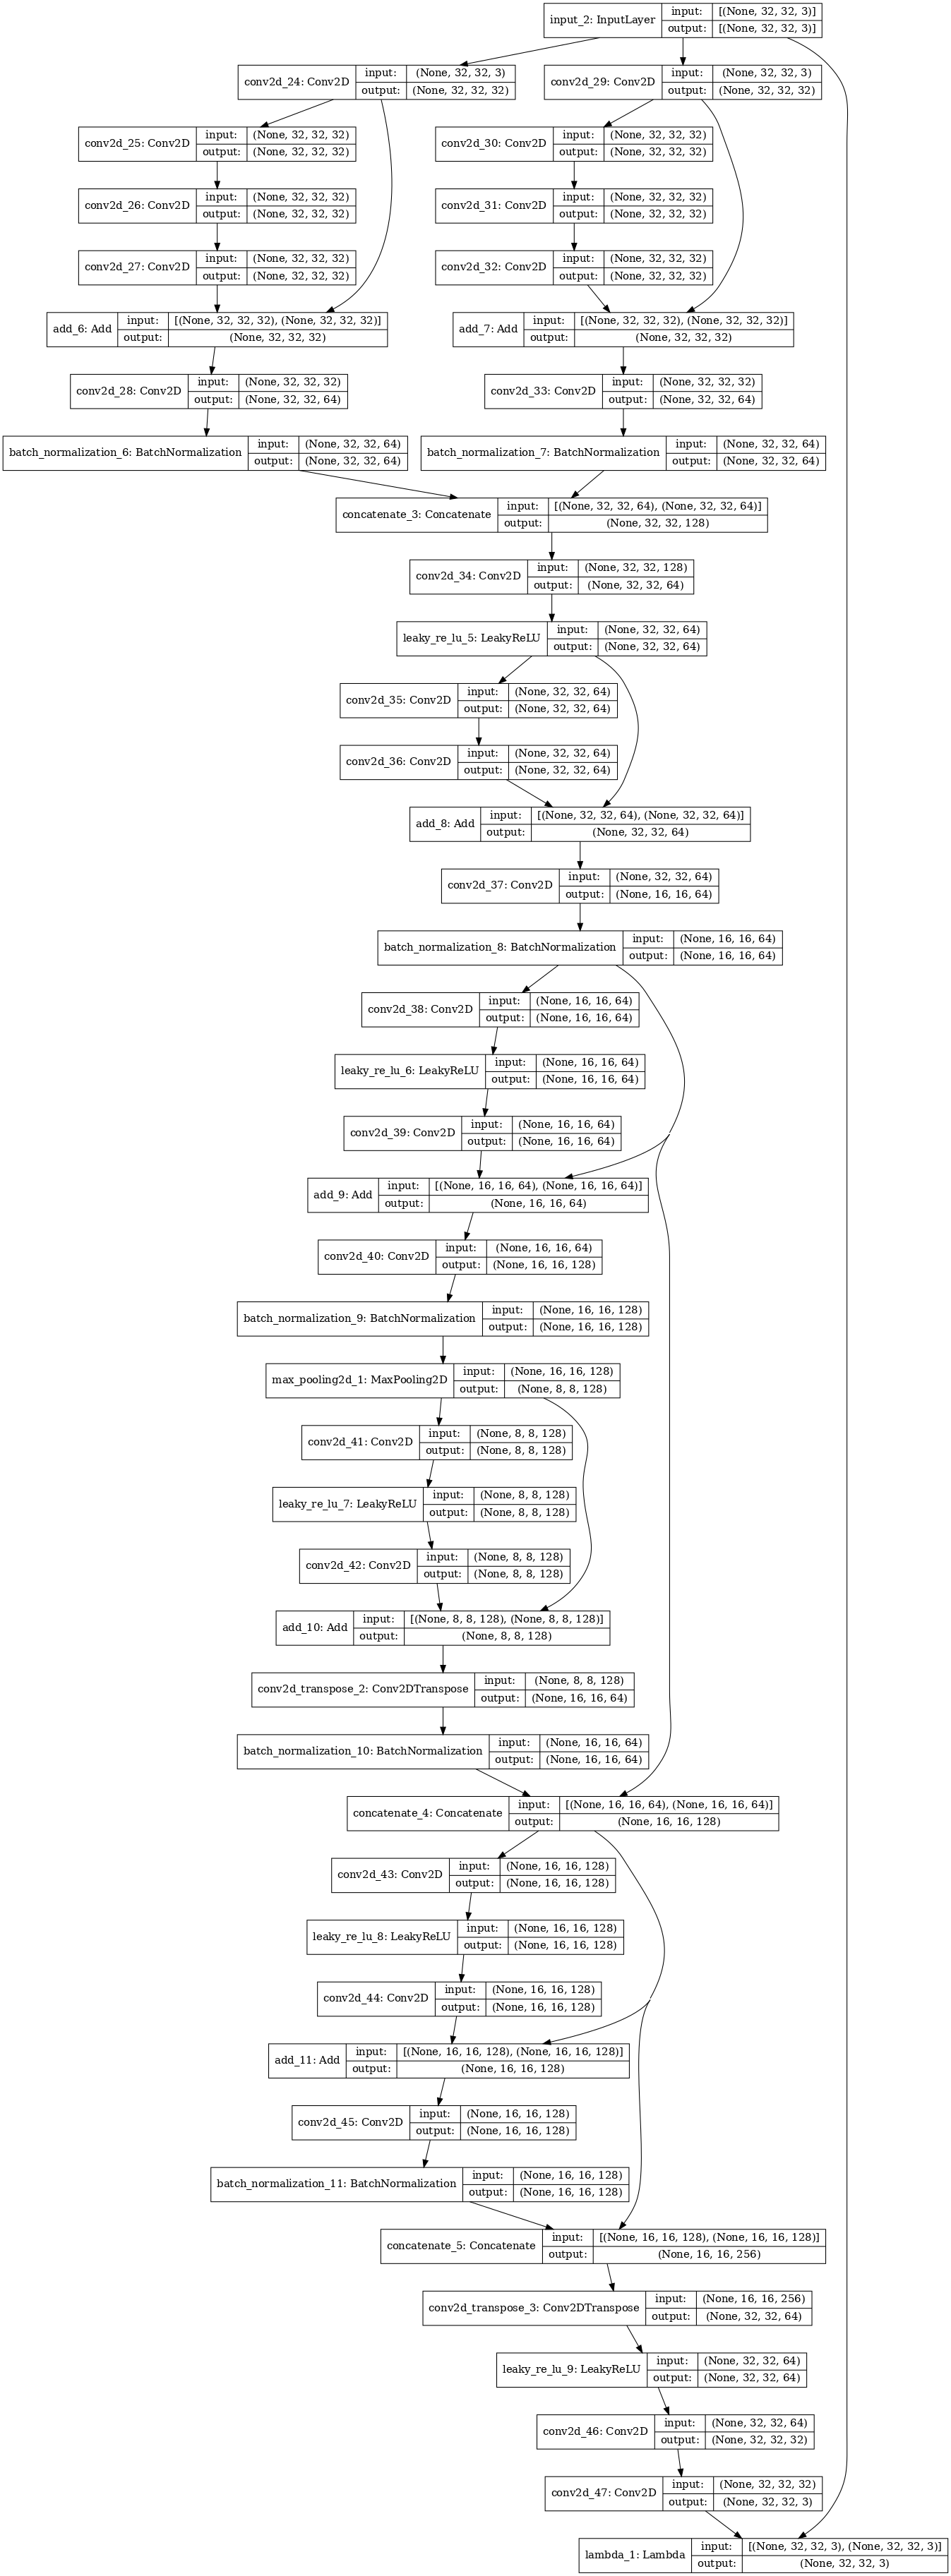

In [ ]:
plot_model(ae_inpainting, show_shapes=True, dpi=76)

## Callbacks

here I assign to different variables two callbacks provided by Keras that allow to:

1. Reduce the learning rate when a metric has stopped improving after *n* epochs.
2. Stop training when a monitored metric, in this case the loss (Mean Squared error) computed on the validation set, has stopped improving after *n* epochs.

Note that the EarlyStopping callback restores the model weights from the epoch with the best value of the monitored quantity.

In [ ]:
stop_training = callbacks.EarlyStopping(monitor="val_loss", mode="auto", patience=15, restore_best_weights=True)
reduce_learning_rate = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=6, min_lr=0.000001)

## Compile model

As loss function I set the Mean Squared Error, which is indeed what I want to minimize. On the other hand, as metrics I set accuracy, but just to look at training performance from another point of view.

In [ ]:
ae_inpainting.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics='accuracy')

## Training

After having tested different configurations, with this specific model architecture i found that 32 was optimal as a batch size. I set validation split to 0.1 in order to have an adequate amound of data for training only. Note that i set the epochs value to 100, but since in the *fit* method also the callbacks are passed, after *n* epochs the training automatically stops and restores the best weights according to the loss function monitored on the validation data. 

In [ ]:
ae_inpainting.fit(x=masked_x_train, y=x_train, validation_split=0.1, batch_size=32, epochs=100, verbose=1, shuffle=True, callbacks=[reduce_learning_rate, stop_training])

Epoch 1/100
1407/1407 [==============================] - 40s 27ms/step - loss: 0.0096 - accuracy: 0.8750 - val_loss: 0.0090 - val_accuracy: 0.8847
Epoch 2/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0087 - accuracy: 0.8948 - val_loss: 0.0085 - val_accuracy: 0.8897
Epoch 3/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0084 - accuracy: 0.9002 - val_loss: 0.0084 - val_accuracy: 0.8873
Epoch 4/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0082 - accuracy: 0.9028 - val_loss: 0.0081 - val_accuracy: 0.8951
Epoch 5/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0080 - accuracy: 0.9051 - val_loss: 0.0079 - val_accuracy: 0.9050
Epoch 6/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0078 - accuracy: 0.9064 - val_loss: 0.0080 - val_accuracy: 0.9062
Epoch 7/100
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0076 - accuracy: 0.9078 - val_loss: 0

## Prediction and final measurements

In [ ]:
predictions = ae_inpainting.predict(x=masked_x_test, verbose=0)

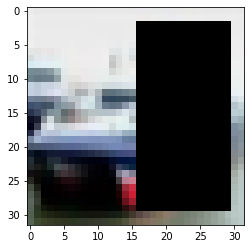

In [ ]:
plt.imshow(masked_x_test[1])
plt.show()

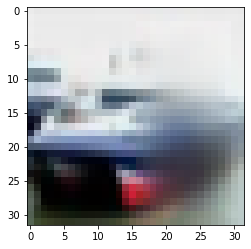

In [ ]:
plt.imshow(predictions[1])
plt.show()

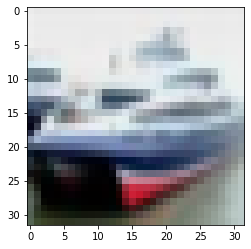

In [ ]:
plt.imshow(x_test[1])
plt.show()

In [ ]:
from keras import backend as K
# calculate the MSE between the predictions and ground truth
mse = K.mean(K.square(x_test - predictions))
# evaluate the model
print('Mean Squared Error:', K.eval(mse))

Mean Squared Error: 0.007867773


In [ ]:
mse = np.mean(np.square(predictions - x_test),axis=1)
print(mse.shape)
print(np.mean(mse))
print(np.std(mse))

(10000, 32, 3)
0.007867775
0.016019605
